# MLP Language Model

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/fitter-happier-models/blob/master/docs/notebooks/language-modeling/02-mlp.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/fitter-happier-models?style=social)](https://github.com/particle1331/fitter-happier-models)

---

## Introduction

In this notebook, we implement a **multilayer perceptron** (MLP) character-level language model. We will improve our previous bigram character-level language model for maximizing the likelihood of next characters by passing embeddings of characters in its context to an MLP network. Instead of learning a large lookup table for each character sequence as in the previous notebook, here the embedding vectors are combined to make a prediction, allowing for better generalization with less parameters to learn. This notebook is based on the lecture {cite}`makemore2`.

In [ ]:
import torch

import math
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
TRAIN_RATIO = 1.0

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

Same **names dataset** as previous notebook:

In [ ]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
names = names[:int(TRAIN_RATIO * len(names))]

print(len(names))
names[:10]

32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

```{figure} ../../img/char-dataset.drawio.svg
---
width: 330px
name: char-dataset.drawio
---

Using a **block size** of 3 to sample training examples for the name `'olivia'`. Each row indicates an input-output pair in the training dataset, where the input block is represented by the orange cubes, and the blue block highlights the target character.
```

We define a helper class for sampling input-output pairs from the names dataset. The parameter `block_size` refers to the fixed number of previous characters that the model will use for predicting the next one.

In [ ]:
class CharDataset:
    def __init__(self, names: list[str], block_size: int):
        self.names = names
        self.chars = ['.'] + sorted(list(set(''.join(names))))
        self.block_size = block_size
        self.itos = dict(enumerate(self.chars))
        self.stoi = {c: i for i, c in self.itos.items()}

    def decode(self, x):
        return ''.join(self.itos[i] for i in x)

    def encode(self, word):
        return [self.stoi[c] for c in word]

    def build_dataset(self):
        """Creating subsequences -> next character target."""
        xs = []
        ys = []
        for name in self.names:
            context = ['.'] * self.block_size
            for c in name + '.':
                xs.append(self.encode(''.join(context)))
                ys.append(self.stoi[c])
                context = context[1:] + [c]
        
        return torch.tensor(xs), torch.tensor(ys)

Note that we simply encode each character in a block to its corresponding integer.

In [ ]:
import pandas as pd

dataset = CharDataset(names, block_size=3)
itos = dataset.itos
stoi = dataset.stoi

xs, ys = dataset.build_dataset()

df = pd.DataFrame({'xs': list(xs.numpy()), 'ys': list(ys.numpy())})
df['seq'] = df['xs'].apply(lambda x: ''.join(itos[c] for c in x))
df['target'] = df['ys'].map(itos)
df.head(12)

,xs,ys,seq,target
0,"[0, 0, 0]",5,...,e
1,"[0, 0, 5]",13,..e,m
2,"[0, 5, 13]",13,.em,m
3,"[5, 13, 13]",1,emm,a
4,"[13, 13, 1]",0,mma,.
5,"[0, 0, 0]",15,...,o
6,"[0, 0, 15]",12,..o,l
7,"[0, 15, 12]",9,.ol,i
8,"[15, 12, 9]",22,oli,v
9,"[12, 9, 22]",9,liv,i


In the experiments, we will stick with setting `block_size=3` for all our models. Using a larger block size does not make sense since most names have around 6 to 7 characters.

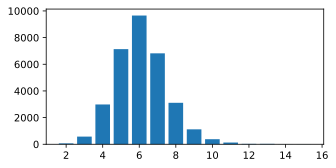

In [ ]:
from collections import Counter

count = Counter([len(n) for n in names])
plt.figure(figsize=(5, 2.5))
plt.bar(count.keys(), count.values());

## Character embeddings

Recall that the names we generated using bigrams were pretty bad. Trigrams improve this a bit. But it required a significantly larger matrix. Indeed, the number of rows of the count matrix grows exponentially with context size. There is not enough data to train such a model.

Instead, our models will learn an **embedding** for each character, i.e. learnable vector representations of characters, along with the parameters of the MLP network for combining the embedding vectors to calculate probabilities. This model architecture is based on  {cite}`bengio2003a`.

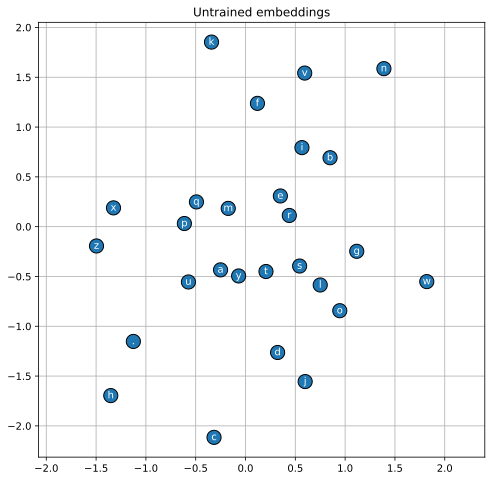

In [ ]:
import torch
import string

g = torch.Generator().manual_seed(0)
C = torch.randn(27, 2, generator=g)
chars = '.' + string.ascii_lowercase

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200, zorder=3, edgecolors='black')
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), chars[i], ha="center", va="center", color='white')

plt.grid('minor')
plt.axis('equal')
plt.title("Untrained embeddings");

Initially, the vector representation of the characters are randomly distributed in the *m*-dimensional space. This embedding will be tuned by the network so that similar characters moves closer to each other in the embedding space. 

Unlike in our previous model for *n*-grams which essentially learns a lookup table, this can easily represent character sequences that are out-of-distribution, i.e. those that appear very rarely in the training data. The embedding allows transfer of knowledge for different contexts by means of character similarity. This allows the model to generalize better. 

## Network architecture

We will implement the neural network shown in the following figure. 
The first component of the network is an embedding matrix, where each row corresponds to an embedding vector. Then, the embedding vectors are concatenated in the correct order and passed to the 2-layer MLP. Here the first layer applies tanh nonlinearity, while the second layer simply performs a linear operation to get the logits. 

Note that during training the weights of the MLP adjusts for character ordering in the input block. And parameters are modified such that the predict probability of the next character is maximized. These include the parameters of the layers as well as the embedding table. To get the unnormalized distribution, we simply apply `.exp()` on the logits. Note that the input and output layer of the network has the same width.

```{figure} ../../img/mlp-char-level.drawio.svg
---
width: 600px
name: mlp-char-level.drawio
---

Schematic diagram of our MLP neural net with embedding and block size of 3. Shown here is the input string `"ner"` passed to the embedding layer. The resulting concatenation of embeddings are passed to the two-layer MLP with logits. Note that the embeddings are concatenated in the correct order.
```

Note that the construction of the embedding vector can be expressed as a matrix multiplication with inputs as concatenated one hot vectors. The matrix is a block matrix consisting of the embedding matrix with **shared weights**. Weight sharing is important since we want to have the same embedding for all slots in the input block. Expressing this operation as matrix multiplication allows us to easily write an explicit backward method for this operation.

```{figure} ../../img/embedding.drawio.svg
---
width: 450px
name: embedding.drawio
---
Construction of the input to the MLP as matrix multiplication. The input vector is rotated for the sake of presentation. The matrix consists of blocks of shared weights of the embedding matrix. Observe that the length of the resulting vector is equal to the product of the block size and the embedding size.
```

In [ ]:
class MLP:
    def __init__(self, embedding_size, width, block_size, seed=2147483647):
        self.width = width
        self.blk_size = block_size
        self.emb_size = embedding_size
        self._init_weights(seed)
        
    def _init_weights(self, seed):
        self.g = torch.Generator().manual_seed(seed)
        self.C  = torch.randn(27, self.emb_size,                           generator=self.g)
        self.W1 = torch.randn((self.blk_size * self.emb_size, self.width), generator=self.g)
        self.b1 = torch.randn(self.width,                                  generator=self.g)
        self.W2 = torch.randn((self.width, 27),                            generator=self.g)
        self.b2 = torch.randn(27,                                          generator=self.g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, xs: list[int]):
        x = self.C[xs].view(-1, self.blk_size * self.emb_size)
        h = torch.tanh(x @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def zero_grad(self):
        for p in self.parameters:
           p.grad = None        

**Remark.** Using `.view` so that the same underlying storage of the tensor is used in the computation.

### Model training

Optimizing `F.cross_entropy` loss which expects logits (unnormalized scores). This is equivalent to maximizing next character likelihood.

In [ ]:
import torch.nn.functional as F


def optim_step(model, lr):
    for p in model.parameters:
        p.data -= lr * p.grad

def train_model(model, xs, ys, num_steps=100, lr=0.1):
    
    losses = []
    for k in range(num_steps):
        logits = model(xs)
        loss = F.cross_entropy(logits, target=ys)

        model.zero_grad()
        loss.backward()
        optim_step(model, lr=lr)

        # logging
        losses.append(loss.item())
        if (k % (num_steps // 10) == 0) or (k == num_steps - 1):
            print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")
    
    return losses


model = MLP(embedding_size=2, width=100, block_size=3)
hist = train_model(model, xs, ys, num_steps=100, lr=0.1)

[001/100]   loss=19.5052
[011/100]   loss=10.7096
[021/100]   loss=8.3292
[031/100]   loss=6.7950
[041/100]   loss=5.8032
[051/100]   loss=5.1055
[061/100]   loss=4.5874
[071/100]   loss=4.2026
[081/100]   loss=3.9281
[091/100]   loss=3.7287
[100/100]   loss=3.5892


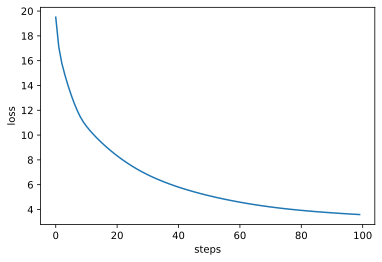

In [ ]:
plt.plot(hist)
plt.ylabel('loss')
plt.xlabel('steps');

### Using mini-batches

It is crucial to use **mini-batches** to approximate the gradient. This leads to noisier and more updates, but drastically reduces the resources needed for training. Updating training function:

In [ ]:
def train_step(model, xs_trn, ys_trn, generator, batch_size=32, lr=0.1):
    """One step of backprop and weight update."""
    
    B = torch.randint(0, xs_trn.shape[0], (batch_size,), generator=generator)
    logits = model(xs_trn[B])
    loss = F.cross_entropy(logits, target=ys_trn[B])

    model.zero_grad()
    loss.backward()
    optim_step(model, lr=lr)

    return loss.item()


def train_model(
        model, 
        xs_trn, ys_trn, 
        batch_size, 
        num_steps, 
        lr=0.1, 
        verbose=True, seed=42
    ):

    losses = []
    g = torch.Generator().manual_seed(seed)
    for k in range(num_steps):
        
        loss = train_step(model, xs_trn, ys_trn, g, batch_size, lr)

        # logging
        losses.append(loss)
        if verbose and ((k % (num_steps // batch_size) == 0) or (k == num_steps - 1)):
            print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]   loss: {loss:.4f}")

    return losses


model = MLP(embedding_size=2, width=100, block_size=3)
hist = train_model(model, xs, ys, batch_size=32, num_steps=10000, lr=0.1)

[00001/10000]   loss: 17.3533
[00313/10000]   loss: 3.1909
[00625/10000]   loss: 2.3746
[00937/10000]   loss: 2.9336
[01249/10000]   loss: 2.7388
[01561/10000]   loss: 2.6701
[01873/10000]   loss: 2.6746
[02185/10000]   loss: 2.3285
[02497/10000]   loss: 2.8161
[02809/10000]   loss: 2.6688
[03121/10000]   loss: 2.4861
[03433/10000]   loss: 2.3500
[03745/10000]   loss: 2.3921
[04057/10000]   loss: 2.4572
[04369/10000]   loss: 2.6916
[04681/10000]   loss: 2.4224
[04993/10000]   loss: 2.1262
[05305/10000]   loss: 2.4351
[05617/10000]   loss: 2.5598
[05929/10000]   loss: 2.3319
[06241/10000]   loss: 2.6329
[06553/10000]   loss: 2.5195
[06865/10000]   loss: 2.7876
[07177/10000]   loss: 2.5837
[07489/10000]   loss: 2.6217
[07801/10000]   loss: 2.2596
[08113/10000]   loss: 2.4977
[08425/10000]   loss: 2.4559
[08737/10000]   loss: 2.6493
[09049/10000]   loss: 2.5435
[09361/10000]   loss: 2.5106
[09673/10000]   loss: 2.3888
[09985/10000]   loss: 2.6498
[10000/10000]   loss: 2.2048


Noisier updates:

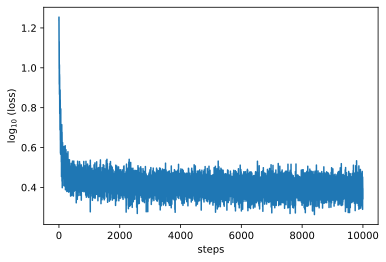

In [ ]:
plt.plot(torch.tensor(hist).log10(), )
plt.xlabel("steps")
plt.ylabel("$\log_{10}$ (loss)");

## Tuning the hyperparameters

To clean up our experimentation code, let us create a trainer class that collects all objects that will be used during training, and also make the training code more readable. For example, this allows us to simply call `trainer.run(n)` to run training with `n` steps. Note that also implement an additional new method `lr_finder` which we will discuss shortly.

In [ ]:
class Engine:
    def __init__(self,
            model,
            x_train, y_train,
            x_valid, y_valid,
            learning_rate=0.1,
            batch_size=32,
            seed=42
        ):

        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        self.generator = torch.Generator().manual_seed(seed)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        self._loss_train = {}
        self._loss_valid = {}
        self._lr_counter = 0
        self._best_valid_loss = float("inf")


    def train_step(self, x, y, lr):
        """One step of backward pass and weight update."""
        
        logits = self.model(x)
        loss = F.cross_entropy(logits, target=y)

        self.model.zero_grad()
        loss.backward()
        optim_step(self.model, lr=lr)

        return loss.item()

        
    def run(self, num_steps, verbose=True):
        """Run training with given no. of optim steps."""

        for k in range(num_steps):
            x, y = self.sample_batch()
            loss = self.train_step(x, y, lr=self.learning_rate)
            self._loss_train[k] = loss
            
            if (k % (num_steps // self.batch_size) == 0) or (k == num_steps - 1):
                loss_valid = self.evaluate(self.x_valid, self.y_valid)
                self._loss_valid[k] = loss_valid
                self.lr_step(loss_valid, verbose)
                if verbose:
                    print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]      loss={loss:<8.4f}    val_loss={loss_valid:.4f}")

        return {
            "loss_train": self._loss_train,
            "loss_valid": self._loss_valid
        }


    def lr_finder(self, num_steps=1000, lre_min=-3, lre_max=0, plot=False, color='C0'):
        """Finding a good base learning rate for training."""

        # Training loss at each step
        lre = torch.linspace(lre_min, lre_max, num_steps)
        lrs = 10 ** lre
        
        losses = []
        for k in range(num_steps):
            x, y = self.sample_batch()
            loss = self.train_step(x, y, lr=lrs[k])
            losses.append(loss)

        # Moving average of previous losses
        w = num_steps // 20    # i.e. 1/2 (num_steps // 10)
        loss_ma = []
        for i in range(w, num_steps - w):
            loss_ma.append((lre[i], sum(losses[i-w: i+w]) / (2 * w)))

        # Minimum of MA curve as best learning rate
        best_lre = min(loss_ma, key=lambda x: x[1])[0]
        assert lre_min < best_lre < lre_max

        # Plotting
        if plot:
            plt.figure(figsize=(5, 2.5))
            plt.plot(lre, torch.tensor(losses).numpy(), alpha=0.2, color=color)
            plt.ylabel('loss')
            plt.xlabel('lr exponent')
            plt.plot([l[0] for l in loss_ma], [l[1] for l in loss_ma], color=color)
            plt.axvline(best_lre, linestyle='dashed', linewidth=1.2, color='black', zorder=-1)

        lr0 = 10 ** best_lre.item()
        print(f"Setting learning rate to {lr0:.2e}")
        self.learning_rate = lr0


    @torch.no_grad()
    def evaluate(self, x, y):
        loss = F.cross_entropy(self.model(x), y)
        return loss.item()

    def sample_batch(self):
        B = torch.randint(
            0, self.x_train.shape[0], 
            (self.batch_size,), 
            generator=self.generator
        )     
        x = self.x_train[B]
        y = self.y_train[B]
        return x, y

    def lr_step(self, loss_valid, verbose):
        if loss_valid < self._best_valid_loss:
            self._best_valid_loss = loss_valid
            self._lr_counter = 0
        else:
            self._lr_counter += 1
            if self._lr_counter == 3:
                self.learning_rate *= 0.1
                self._lr_counter = 0
                if verbose:
                    print(f"Decreasing learning rate to {self.learning_rate:.2e}")


To tune our network, we need to have a validation set:

In [ ]:
from sklearn.model_selection import StratifiedKFold

def create_folds(x, y, seed=42):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros(x.shape[0])
    for fold, (train_, valid_) in enumerate(kf.split(x, y)):
        folds[valid_] = fold

    x_train, y_train = x[folds >  1], y[folds >  1]
    x_valid, y_valid = x[folds == 1], y[folds == 1]
    x_test,  y_test  = x[folds == 0], y[folds == 0]

    return x_train, y_train, x_valid, y_valid, x_test, y_test


x_train, y_train, \
x_valid, y_valid, \
x_test,  y_test = create_folds(xs, ys)

### Finding a good base learning rate

This method gradually increases the learning rate linearly within a fixed range, and number of steps in its exponent, and performs gradient descent at each step while recording the loss. The chosen learning rate is the largest before the loss destabilizes. On the other hand, during training, we work backwards by decreasing the learning rate via a **schedule**. This is an empirical heuristic that works well in practice (and is very cheap to compute).

Setting learning rate to 1.82e-01


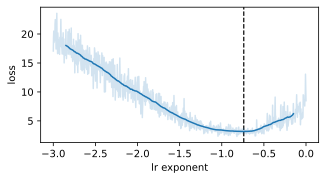

In [ ]:
trainer = Engine(
    MLP(embedding_size=2, width=100, block_size=3),
    x_train, y_train,
    x_valid, y_valid,
    batch_size=32
)
trainer.lr_finder(num_steps=1000, lre_min=-3, lre_max=0, plot=True)

Note that we choose a large enough range and number of steps such that we can see a well-defined U-shape in the curve. The `assert` statement allows us to make sure this is satisfied without having to visualize the plot. Also, observe that the minibatches from the training dataset is used as input, since we want to mimic how the learning rate affects training.

### Increasing network width

Training with different network widths:

In [ ]:
from tqdm import tqdm_notebook as tqdm

results = {}
for i, h in tqdm(enumerate(range(100, 1000, 100))):
    trainer = Engine(
        MLP(embedding_size=2, width=h, block_size=3),
        x_train, y_train,
        x_valid, y_valid,
        batch_size=32
    )
    trainer.lr_finder()
    results[h] = trainer.run(200000, verbose=False)

0it [00:00, ?it/s]

Setting learning rate to 1.82e-01
Setting learning rate to 8.95e-02
Setting learning rate to 8.47e-02
Setting learning rate to 6.12e-02
Setting learning rate to 6.12e-02
Setting learning rate to 4.91e-02
Setting learning rate to 4.27e-02
Setting learning rate to 4.21e-02
Setting learning rate to 4.97e-02


Plotting training history:

0it [00:00, ?it/s]

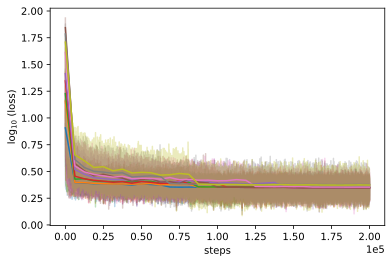

In [ ]:
for i, h in tqdm(enumerate(range(100, 1000, 100))):    
    hist = results[h]
    plt.plot(hist['loss_train'].keys(), torch.tensor(list(hist['loss_train'].values())).log10(), color=f"C{i}", alpha=0.3)
    plt.plot(hist['loss_valid'].keys(), torch.tensor(list(hist['loss_valid'].values())).log10(), color=f"C{i}", zorder=3)

plt.xlabel("steps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel("$\log_{10}$ (loss)");

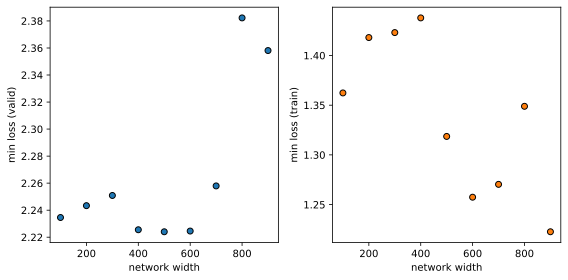

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(results.keys(),[min(results[h]['loss_valid'].values()) for h in results.keys()], edgecolor='black', color='C0')
ax[1].scatter(results.keys(),[min(results[h]['loss_train'].values()) for h in results.keys()], edgecolor='black', color='C1')
ax[0].set_xlabel('network width')
ax[1].set_xlabel('network width')
ax[0].set_ylabel('min loss (valid)');
ax[1].set_ylabel('min loss (train)');
fig.tight_layout()

It looks like increasing the network width only results in the network overfitfing the training dataset. Our guess is that embedding size acts like a **bottleneck** to network capacity. We investigate this in a later section.

### Trained character embeddings

In this section we will look at embeddings of chacters in two-dimensional space. Recall from the network structure that, vectors with similar embeddings have similar roles in predicting the next character. 

In [ ]:
trainer = Engine(
    MLP(embedding_size=2, width=100, block_size=3),
    x_train, y_train,
    x_valid, y_valid,
    batch_size=32
)
trainer.lr_finder()
trainer.run(200000);

Setting learning rate to 1.82e-01
[000001/200000]      loss=8.8389      val_loss=8.0743
[006251/200000]      loss=2.8182      val_loss=2.4955
[012501/200000]      loss=2.3431      val_loss=2.4641
[018751/200000]      loss=2.2389      val_loss=2.4306
[025001/200000]      loss=2.5486      val_loss=2.4351
[031251/200000]      loss=2.3194      val_loss=2.4281
[037501/200000]      loss=2.9085      val_loss=2.3986
[043751/200000]      loss=2.1340      val_loss=2.3616
[050001/200000]      loss=2.5341      val_loss=2.4255
[056251/200000]      loss=2.4494      val_loss=2.3867
Decreasing learning rate to 1.82e-02
[062501/200000]      loss=2.3295      val_loss=2.3659
[068751/200000]      loss=1.8157      val_loss=2.2620
[075001/200000]      loss=2.1306      val_loss=2.2538
[081251/200000]      loss=2.3186      val_loss=2.2572
[087501/200000]      loss=1.9571      val_loss=2.2542
[093751/200000]      loss=2.0579      val_loss=2.2514
[100001/200000]      loss=2.4785      val_loss=2.2527
[106251/200

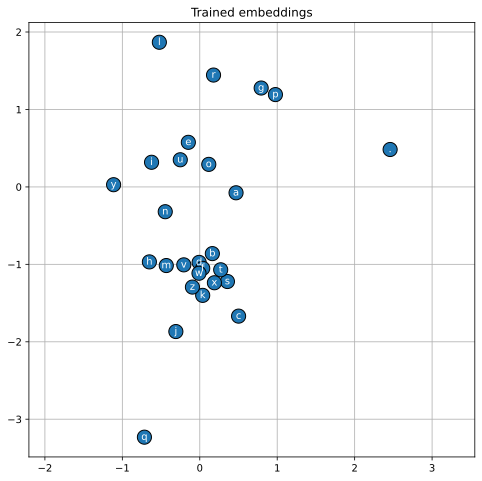

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(trainer.model.C[:, 0].data, trainer.model.C[:, 1].data, s=200, edgecolors='black', zorder=3)
for i in range(27):
    plt.text(trainer.model.C[i, 0].item(), trainer.model.C[i, 1].item(), itos[i], ha="center", va="center", color='white')

plt.grid('minor')
plt.axis('equal')
plt.title("Trained embeddings");

Observe that the vowels are clustered together with `y`. And there are vectors such as `q` and `.` that are far away from other vectors. We can say that the network has learned these characters. On the other hand, the other consonants being clustered too tightly indicates that the network is not able to understand the subtle differences with these characters, hence just grouping them together.

It seems like it will be difficult improve this with further training or improvements to the network hyparameters. Indeed, we saw that increasing network width, which should have resulted in overfitting the training set, resulted in increasing train and validation losses. In the next section, we will increase the number of dimensions of the embedding space and see whether this improves performance.

### Increasing the embedding dimension

Based on our previous observations, we consider increasing embedding size to 10. Note that we increase the width of the MLP to account for the increase in the number of input neurons.

In [ ]:
trainer = Engine(
    MLP(embedding_size=10, width=200, block_size=3),
    x_train, y_train,
    x_valid, y_valid,
    batch_size=32
)
trainer.lr_finder(1000, lre_min=-3, lre_max=0.4)
hist = trainer.run(200000)

Setting learning rate to 1.68e-01
[000001/200000]      loss=28.8424     val_loss=25.2377
[006251/200000]      loss=2.7713      val_loss=2.6589
[012501/200000]      loss=2.3136      val_loss=2.5892
[018751/200000]      loss=2.3239      val_loss=2.4722
[025001/200000]      loss=2.3669      val_loss=2.4879
[031251/200000]      loss=2.4556      val_loss=2.4844
Decreasing learning rate to 1.68e-02
[037501/200000]      loss=2.4650      val_loss=2.5302
[043751/200000]      loss=1.8411      val_loss=2.2180
[050001/200000]      loss=2.1465      val_loss=2.2082
[056251/200000]      loss=2.2330      val_loss=2.2126
[062501/200000]      loss=2.1064      val_loss=2.2114
Decreasing learning rate to 1.68e-03
[068751/200000]      loss=1.8020      val_loss=2.2111
[075001/200000]      loss=1.8279      val_loss=2.1902
[081251/200000]      loss=2.2535      val_loss=2.1893
[087501/200000]      loss=1.9275      val_loss=2.1883
[093751/200000]      loss=1.8489      val_loss=2.1882
[100001/200000]      loss=2

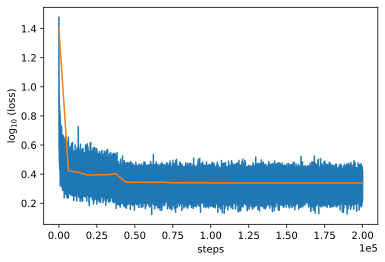

In [ ]:
plt.plot(hist['loss_train'].keys(), torch.tensor(list(hist['loss_train'].values())).log10())
plt.plot(hist['loss_valid'].keys(), torch.tensor(list(hist['loss_valid'].values())).log10())

plt.xlabel("steps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.ylabel("$\log_{10}$ (loss)");

In [ ]:
trainer.evaluate(x_valid, y_valid)

2.184441328048706

## Sampling names

Finally, we look at names generated by the model.

In [ ]:
def generate_names(model, block_size, sample_size, seed=2147483647):
    """Generate names from a Markov process with cond probability table P."""

    g = torch.Generator().manual_seed(seed)
    names = []
    for _ in range(sample_size):
        out = []
        context = [0] * block_size
        while True:
            p = model(torch.tensor(context)).exp()
            j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            if j == 0:
                break
            context = context[1:] + [j]
            out.append(itos[j])
        names.append(''.join(out))
    return names


def name_loss(name, model, block_size):
    nll = 0.0
    context = [0] * block_size
    for c in name + '.':
        p = F.softmax(model(torch.tensor(context))).reshape(-1)[stoi[c]]
        nll += -math.log(p)
        context = context[1:] + [stoi[c]]
    return nll / (len(name) + 1)


sample = generate_names(trainer.model, block_size=3, sample_size=12, seed=0)
name_losses = {n: name_loss(n, trainer.model, block_size=3) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<22} {name_losses[n]:.3f}")


leigh                  1.215
rosel                  1.757
leia                   1.845
rasana                 1.858
lia                    2.076
ric                    2.225
kumetre                2.268
zrokaymeni             2.324
lio                    2.347
ollis                  2.353
ymishia                2.657
zegar                  2.812


Nice! This is a huge improvement from our previous notebook.